# Import Libraries 

In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.4
Scikit-Learn 1.0.2
GPU is available


In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import itertools
import os
import cv2
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter(action= 'ignore', category=FutureWarning)
%matplotlib inline
pd.set_option('display.max_colwidth', None)

In [2]:
def plot_history_from_saved_ckpt(hist):
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']

    loss= hist['loss']
    val_loss = hist['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [3]:
def create_cnn():

    # Instantiate a CNN.
    cnn_model = Sequential()

    # Add a convolutional layer.
    cnn_model.add(Conv2D(filters=22,             # number of filters
                        kernel_size=(3,3),      # height/width of filter
                        activation='relu',      # activation function 
                        padding = 'same',
                        input_shape=(224,224,3))) # shape of input (image)

    # Add a pooling layer.
    cnn_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

    # Add another convolutional layer.
    cnn_model.add(Conv2D(44,
                        kernel_size=(3,3),
                        padding = 'same',
                        activation='relu'))

    # Add another pooling layer.
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))

    # We have to remember to flatten to go from the "box" to the vertical line of nodes!
    cnn_model.add(Flatten())

    # Add a densely-connected layer with 88 neurons.
    cnn_model.add(Dense(88, activation='relu'))

    # Let's try to avoid overfitting!+
    cnn_model.add(Dropout(0.2))

    # Add a densely-connected layer with 44 neurons.
    cnn_model.add(Dense(44, activation='relu'))

    # Let's try to avoid overfitting!
    cnn_model.add(Dropout(0.2))

    # Add a final layer 
    cnn_model.add(Dense(len(classes), activation='softmax'))

    # Compile model
    cnn_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

    return cnn_model

# Load dataset

In [4]:
# instantiate path to train and test path
train_path = '../data/dataset_unbalanced/train/'
test_path = '../data/dataset_unbalanced/val/'

In [5]:
# this cell is used to generate unique classes of vegetables 

folders = glob.glob(train_path + '*')

train_list = pd.DataFrame(glob.glob(train_path + '*')).rename(columns = {0: 'name'})
# generate ordinal categories for y

train_list['class_name'] = train_list.name.apply(lambda x: x.split("\\")[1])

classes = train_list['class_name'].unique().tolist()

In [6]:
# generate train and test batches using imagedatagenerator 

train_batches = data_generator = ImageDataGenerator(
    rescale = 1./225,
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 20,
    brightness_range = [0.6,1.2],
     ).flow_from_directory(directory = train_path, target_size = (224,224), class_mode = 'categorical', batch_size = 32)

test_batches = ImageDataGenerator(
    rescale = 1./225,
).flow_from_directory(directory = test_path, target_size = (224,224), class_mode = 'categorical',batch_size = 32)

Found 52090 images belonging to 22 classes.
Found 10443 images belonging to 22 classes.


# Initial Base model performance

Taking model baseline score from **Journal:** `3_Initial CNN_&_Data_Augmentation`

We will compare with `CNN_Iteration_1` for subsequent models

In [42]:
summary_df = pd.read_csv('../logs/checkpoint/summary_df.csv').drop(columns = 'Unnamed: 0')
summary_df = summary_df.set_index(pd.Index([1,2,3]))
summary_df

,Model,Preprocessing/Data Augmentaion,Epoch,Trainable Parameters,Duration per epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy
1,Base_Model: CNN,No Data Augmentation,10,"12,156,958",81s,0.180662,0.322523,0.942140,0.919763
2,CNN | Data Augmentation: Iteration 1,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",557s,0.454702,0.282578,0.852738,0.912390
3,CNN | Data Augmentation: Iteration 2,"Gaussian Effect, Horizontal_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",621s,0.377037,0.281738,0.874796,0.911624


# Transfer learning with established neural network architecture

From the previous notebook, we can see that even though our self-constructed neural network seems established, it was only able to reap 86% accuracy without overfitting with the use of highly variable dataset. The model was not going to give me any better results wihtout exponentially increasing my training time. 

Since we are only training models with a small dataset of 50,000 images, we should use pre-trained models that have been trained with millions of images from Imagenet. In this manner, we can directly use their weights and architecture obtained and apply the learning on our problem statement. This is essentially what transfer learning is all about. 

One must be wary about the choice of pre-trained model should we use in our case. 

Another beauty of using transfer learning is we can do further fine-tuning for better performance, we can either
1) Unfreeze the top few layers for the model to be trained on, so that the fully connected layers would be more customised to the new dataset
2) Unfreeze all the layers and retrain the model (typically only if the dataset is huge enough or dataset is completely different from the pre-trained images from ImageNet)


The models and iterations helps us understand more of its benefits of transfer learning. 

## **Model #1** - `VGG16`

VGG16 is one of the most popular models designed for image recognition of over 1000 classes. The 16 in VGG16 regers to 16 trainable layers that have weights trained by millions of ImageNet dataset. 

In 2014 ImageNet Classification Challenge, VGG16 achieved 92.7% classification accruacy. Its pre-trained architecture can detect generic visual features present in `Food` dataset. ([learndatasci](https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/))

VGG16 is composed of **13 convolutional layers, 5 max-pooling layers, and 3 fully connected layers**. Generally, its designed with consistent block structures. Each block consists of sequence of **convulational layers of kernel size (3x3)** followed by **max-pooling layers of size (2x2) with strides 2** is also applied to halve the resolution after each block. 

`More details can be seen in the summary table below after the VGG model has been initialised`

**Point to take note**
- Fully connected hidden layers set at 4096 each, followed by an output layer of 1000 neurons corresponding to the number of categories of ImageNet dataset. 
- I would like to remove the top layer, and modify the top layer that resembles similar ratio to the output layer I have for my dataset. 
- Since the dataset we are using have already been augmented, the model will not need regularization as there will be minimal overfitting. 


<img src="../picture_ref/vgg16_architecture2.jpg" width="500"/>

In [8]:
# define VGG Model creation 

def create_vgg_model():
    image_size = [224,224]
    # Initialise VGG16
    vgg = VGG16(input_shape= image_size + [3], weights = 'imagenet', include_top = False)

    # freeze every layers
    vgg.trainable = False
   
    # initial layers 
    X = Flatten()(vgg.output)
    X = Dense(4*len(folders), activation='relu')(X)
    prediction = Dense(len(folders), activation = 'softmax')(X)
    VGG = Model(inputs = vgg.input, outputs = prediction)

    # Compile model
    VGG.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

    return VGG

In [51]:
model_vgg16 = create_vgg_model()

In [52]:
model_vgg16.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

There are a total of 2,209,790 trainable parameters coming from the fully connected layers. The lower layers are all frozen taking pre-trained weights from ImageNet.

In [53]:
# generate vgg fit with checkpoint included per epoch 

checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 )

# Train the model with the new callback
hist = model_vgg16.fit(train_batches, 
                epochs=15,
                validation_data=test_batches,
                steps_per_epoch = len(train_batches),
                validation_steps = len(test_batches),
                callbacks=[cp_callback])  # Pass callback to training

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1628 steps, validate for 327 steps
Epoch 1/15
1627/1628 [============================>.] - ETA: 0s - loss: 0.5589 - accuracy: 0.8209
Epoch 00001: saving model to training_1/cp-0001.ckpt
1628/1628 [==============================] - 599s 368ms/step - loss: 0.5586 - accuracy: 0.8210 - val_loss: 0.2512 - val_accuracy: 0.9113
Epoch 2/15
1627/1628 [============================>.] - ETA: 0s - loss: 0.2576 - accuracy: 0.9117
Epoch 00002: saving model to training_1/cp-0002.ckpt
1628/1628 [==============================] - 580s 356ms/step - loss: 0.2576 - accuracy: 0.9117 - val_loss: 0.1814 - val_accuracy: 0.9397
Epoch 3/15
1627/1628 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9280
Epoch 00003: saving model to training_1/cp-0003.ckpt
1628/1628 [==============================] - 580s 356ms/step - loss: 0.2110 - accuracy: 0.9280 - val_loss: 0.1336 - val_accuracy: 0.9523
Epoch 4/15
1627/1628 [===================

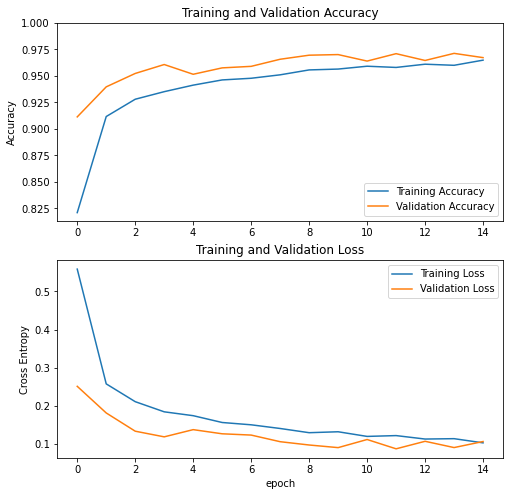

In [54]:
# create history table for acc and loss 

acc_vgg = hist.history['accuracy']
val_acc_vgg = hist.history['val_accuracy']

loss_vgg= hist.history['loss']
val_loss_vgg = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_vgg, label='Training Accuracy')
plt.plot(val_acc_vgg, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_vgg, label='Training Loss')
plt.plot(val_loss_vgg, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
# save history table 
np.save('hist_vgg16.npy',hist.history)

In [57]:
# Saving the model as a saved model formant for possible use later.

model_vgg16.save(f"../models/VGG_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/VGG_model\assets


In [58]:
# Saving the model as a h5 file for possible use later.

model_vgg16.save(f"../models/VGG_model.h5")

In [43]:
# input VGG Initial phase data 
vgg_hist = np.load("../code/hist_vgg16.npy",allow_pickle=True).item()

summary_df.loc[4] = [
    "VGG16 | Initial Phase with 15 Epochs",
    "Horizontal_flip, Vertical_flip,\
    Shear: 20, Brightness_range: [0.6,1.2]",
    15,
    '2,209,790',
    '590s',
    vgg_hist['loss'][-1],
    vgg_hist['val_loss'][-1],
    vgg_hist['accuracy'][-1],
    vgg_hist['val_accuracy'][-1],
                    ]

summary_df

,Model,Preprocessing/Data Augmentaion,Epoch,Trainable Parameters,Duration per epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy
1,Base_Model: CNN,No Data Augmentation,10,"12,156,958",81s,0.180662,0.322523,0.942140,0.919763
2,CNN | Data Augmentation: Iteration 1,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",557s,0.454702,0.282578,0.852738,0.912390
3,CNN | Data Augmentation: Iteration 2,"Gaussian Effect, Horizontal_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",621s,0.377037,0.281738,0.874796,0.911624
4,VGG16 | Initial Phase with 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15,"2,209,790",590s,0.103075,0.106553,0.964869,0.967254


### Fine Tuning

In the feature extraction experiment, you were only training a few layers on top of VGG16 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [59]:
# getting latest checkpoint from VGG16
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_1\\cp-0015.ckpt'

In [60]:
# Create a new model instance
vgg_saved_model = create_vgg_model()

# Load the previously saved weights
vgg_saved_model.load_weights(latest)

# # see total number of trainable weights in saved model
# # and which layers in the saved model are trainable
print("Total trainable weights: {}".format(len(vgg_saved_model.trainable_weights)))

Total trainable weights: 4


In [61]:
vgg_saved_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [62]:
# Re-evaluate the model
loss, acc = vgg_saved_model.evaluate(test_batches, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

  ...
    to  
  ['...']
327/327 - 29s - loss: 0.1066 - accuracy: 0.9673
Restored model, accuracy: 96.73%


In [54]:
# This cell essentially helps to unfreeze total of 7 layers. 

vgg_saved_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(vgg_saved_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
count = 0 
for layer in vgg_saved_model.layers[:fine_tune_at]:
  layer.trainable = False
  count += 1

print(f'Number of frozen layers: {count}')
print(f'Number of unfrozen layers: {len(vgg_saved_model.layers) - count}')

Number of layers in the base model:  22
Number of frozen layers: 15
Number of unfrozen layers: 7


In [55]:
# Check if only blck 5 is trainable together with top layers

for layer in vgg_saved_model.layers:
  if layer.trainable:
    print(layer.trainable, layer.name)

True block5_conv1
True block5_conv2
True block5_conv3
True block5_pool
True flatten_1
True dense
True dense_1


In [56]:
vgg_saved_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [66]:
# For better fine-tuning, RMS propagation was used with lower learning rate

base_learning_rate = 0.001

vgg_saved_model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/100),
    loss= 'categorical_crossentropy',
    metrics=['accuracy']
    )
    

In [67]:
# instantiate initial epocs as 15, and continue training to 30 epochs 
initial_epochs = 15
total_epochs = 30
hist_fine = vgg_saved_model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs,
                         validation_data=test_batches,
                         callbacks = [cp_callback],
                         )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1628 steps, validate for 327 steps
Epoch 16/30
1627/1628 [============================>.] - ETA: 0s - loss: 0.0829 - accuracy: 0.9711
Epoch 00016: saving model to training_1/cp-0016.ckpt
1628/1628 [==============================] - 569s 349ms/step - loss: 0.0828 - accuracy: 0.9712 - val_loss: 0.0716 - val_accuracy: 0.9795
Epoch 17/30
1627/1628 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9806
Epoch 00017: saving model to training_1/cp-0017.ckpt
1628/1628 [==============================] - 581s 357ms/step - loss: 0.0576 - accuracy: 0.9806 - val_loss: 0.0660 - val_accuracy: 0.9793
Epoch 18/30
1627/1628 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9843
Epoch 00018: saving model to training_1/cp-0018.ckpt
1628/1628 [==============================] - 587s 360ms/step - loss: 0.0472 - accuracy: 0.9843 - val_loss: 0.0522 - val_accuracy: 0.9848
Epoch 19/30
1627/1628 [===============

In [68]:
# add on history chart 
acc_vgg += hist_fine.history['accuracy']
val_acc_vgg += hist_fine.history['val_accuracy']

loss_vgg += hist_fine.history['loss']
val_loss_vgg += hist_fine.history['val_loss']

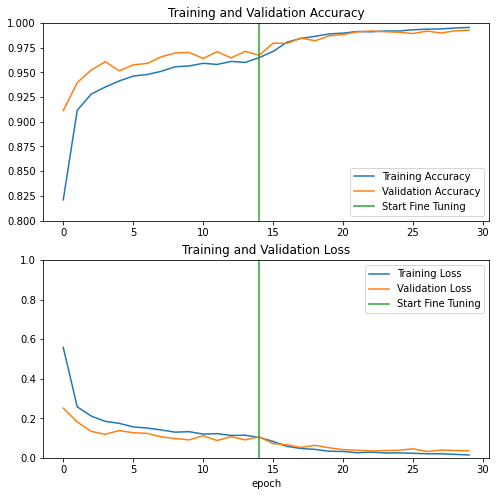

In [69]:
# plot history plot  

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_vgg, label='Training Accuracy')
plt.plot(val_acc_vgg, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_vgg, label='Training Loss')
plt.plot(val_loss_vgg, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [70]:
# Saving the model as a saved model formant for possible use later.

vgg_saved_model.save(f"../models/VGG_model_finetuned")

INFO:tensorflow:Assets written to: ../models/VGG_model_finetuned\assets


In [71]:
# Saving the model as a h5 file for possible use later.

vgg_saved_model.save(f"../models/VGG_model_finetuned.h5")

In [ ]:
# save history plot 

np.save('hist_vgg16_fine.npy',hist_fine.history)

In [9]:
# load model 
vgg_hist_finetuned = np.load("../code/hist_vgg16_fine.npy",allow_pickle=True).item()

In [44]:
# input data from vgg fine_tuned model 
summary_df.loc[5] = [
    "VGG16 | Finetuning with additional 15 Epochs",
    "Horizontal_flip, Vertical_flip,\
    Shear: 20, Brightness_range: [0.6,1.2]",
    '15 + 15',
    '9,289,214',
    '560s',
    vgg_hist_finetuned['loss'][-1],
    vgg_hist_finetuned['val_loss'][-1],
    vgg_hist_finetuned['accuracy'][-1],
    vgg_hist_finetuned['val_accuracy'][-1],
                    ]

summary_df

,Model,Preprocessing/Data Augmentaion,Epoch,Trainable Parameters,Duration per epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy
1,Base_Model: CNN,No Data Augmentation,10,"12,156,958",81s,0.180662,0.322523,0.942140,0.919763
2,CNN | Data Augmentation: Iteration 1,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",557s,0.454702,0.282578,0.852738,0.912390
3,CNN | Data Augmentation: Iteration 2,"Gaussian Effect, Horizontal_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",621s,0.377037,0.281738,0.874796,0.911624
4,VGG16 | Initial Phase with 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15,"2,209,790",590s,0.103075,0.106553,0.964869,0.967254
5,VGG16 | Finetuning with additional 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15 + 15,"9,289,214",560s,0.014331,0.035171,0.995489,0.992627


## **Model #2** - `MobileNetV2`

### **Why MobileNetV2**

I personally picked MobileNetV2 to explore more on the architecture. The architecture delivers high accuracy results while keeping the parameters and mathematical operations as low as possible to bring deep neural networks to mobile devices.

We want to pay attention to daily task that require little hardware support which can be easily trained on our computers. It achieves performance balance performance results and the implementation efficiency. It has low memory requirement for hardware conditions. 

It is very effective feature extractor for object detection and segmentation. The challenge for this model is to study how this pre-trained model will perform for image classification, where it would not be entirely pixel by pixel detail extraction. Hence, we will expect to see some sort of behaviour when training the model later. 


**Architecture**

Idea is we want to have a residual connection. Are we going to take from the bigger output block and use residual connection to the next big box. The idea of inverted residualts, is better to go from the bottleneck, the narrow  to the wide then to narrow again. From a narrow convulation, we use 1x1 Convolution to expand to larger dimensions, then do depth-wise convolutions (channel-wise). The number of resolutions will drop by the value of stride (s) while still maintaining the number of channels. We do 1x1 convolution to reduce the dimensions similar to the input layer. 

What is Relu6, it limits the value of activations to a maximum of 6. the activation is linear as long as its between 0 to 6. According to papers, Relu6 is more robust that regular ReLU when using low-precision computation ([source](https://machinethink.net/blog/mobilenet-v2/))


**3 Main Features**
1) Depth-wise separable convolution 
    - Depth-wise Convolution: Performs lightweight filtering by applying a single convolutional filter per input channel. Channel-wise operations
    - Pointwise Convolution: Uses 1x1 convolution, uses pixel wise, to help build new features through computing linear combinations of the input channels. This kernel has a depth based on how many channels the input image has. 
2) Inverted residual
    - Residual Connections are a type of skip-connection that learn residual functions with reference to the layer inputs, instead of learning unreferenced functions.
    - The idea of inverted residual is taking the narrow layers as the input going through (narrow-wide-narrow concept) rather than taking input from the bigger layer first. 
3) Linear bottleneck 
    - Typically, we use non-linear activation functions like ReLU to discard values lower than 0, as multiple matrix multiplication cannot be reduced to a single numerical operation. 
    - Because we are using inverted residual, our tensors are very low in dimension where the skip connections are linked, hence using a non-linear will hurt the performance of the network leaving out crucial information.  

**Main building block**

<img src="../picture_ref/ResidualBlock.png" width="400"/> <img src="../picture_ref/ResidualBlock_2.png" width="500"/>

- `Expansion layer`: Assuming model receives tensor of size (h:56, w: 56, k: 3), the expansion layer uses 1x1 convolution layer to help to increase dimension by t times. (usually t:6)
- `Depthwise layer`: Depending on the stride (s), it will help to filter the inputs per input channel. The output will have height and width be divided by the number of stride. A 3x3 depthwise convolution is used. 
- `Projection layer`: Uses 1x1 convolution layer to reduce the number of channel back to the input layer to perform residual connection. The output layer does not have activation function as authors found using non-linerity destroys useful information. ([source](https://machinethink.net/blog/mobilenet-v2/))

Segmentation models provide the exact outline of the object within an image. That is, pixel by pixel details are provided for a given object, as opposed to Classification models, where the model identifies what is in an image, and Detection models, which places a bounding box around specific objects.

**Thus I will like to explore the effectiveness of the transfer learning of this model on our vegetable dataset as a Image Classifier.** 


<img src="../picture_ref/mobilenetv2_acrhitecture.png" width="800"/>

### Initial Transfer learning, with only output layers adjusted - 15 epochs

In [16]:
# define function that creates mobilenetV2 model
def create_mobilenet():
    image_size = [224,224]
    #instantiate transfer learning wihtout including top layer
    mobilenetv2 = MobileNetV2(input_shape= image_size + [3], weights = 'imagenet', include_top = False)

    # Freeze all layers first
    mobilenetv2.trainable = False 

    # initial layers 
    x = tf.keras.layers.GlobalAveragePooling2D()(mobilenetv2.output)
    x = tf.keras.layers.Reshape((1, 1, 1280))(x)
    x = tf.keras.layers.Dropout(0.3, name='Dropout')(x)
    x = tf.keras.layers.Conv2D(len(folders), (1, 1), padding='same')(x)
    x = tf.keras.layers.Activation('softmax', name='final_activation')(x)
    prediction = tf.keras.layers.Reshape((len(folders),), name='output')(x)
   
    # create a model object 
    model_mobilenet = Model(inputs = mobilenetv2.input, outputs = prediction)
    
    # Compile model
    model_mobilenet.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    return model_mobilenet

In [87]:
# instantiate MobileNetV2 model

model_mobilenet = create_mobilenet()

In [88]:
# view the structure of the model 

model_mobilenet.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________________________

The total parameters is impressively low as compared to the CNN models and the VGG model.  

In [89]:

# create checkpoint path
checkpoint_path = "training_mobilenet/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
hist_mobile = model_mobilenet.fit(
    train_batches, 
    epochs=15,
    validation_data=test_batches,
    steps_per_epoch = len(train_batches),
    validation_steps = len(test_batches),
    callbacks=[cp_callback]
    )  # Pass callback to training

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1628 steps, validate for 327 steps
Epoch 1/15
1627/1628 [============================>.] - ETA: 0s - loss: 0.4509 - accuracy: 0.8580
Epoch 00001: saving model to training_mobilenet/cp-0001.ckpt
1628/1628 [==============================] - 557s 342ms/step - loss: 0.4508 - accuracy: 0.8581 - val_loss: 0.8949 - val_accuracy: 0.7224
Epoch 2/15
1627/1628 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9124
Epoch 00002: saving model to training_mobilenet/cp-0002.ckpt
1628/1628 [==============================] - 552s 339ms/step - loss: 0.2515 - accuracy: 0.9124 - val_loss: 0.7607 - val_accuracy: 0.7622
Epoch 3/15
1627/1628 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.9181
Epoch 00003: saving model to training_mobilenet/cp-0003.ckpt
1628/1628 [==============================] - 563s 346ms/step - loss: 0.2305 - accuracy: 0.9181 - val_loss: 0.7640 - val_accuracy: 0.7736
Epoch 4/15
1627/1

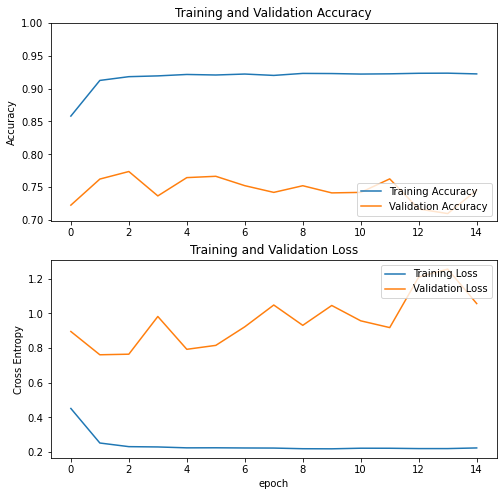

In [92]:
# plot history plot for MobilenetV2 
acc_mobilenet = hist_mobile.history['accuracy']
val_acc_mobilenet= hist_mobile.history['val_accuracy']

loss_mobilenet = hist_mobile.history['loss']
val_loss_mobilenet = hist_mobile.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_mobilenet, label='Training Accuracy')
plt.plot(val_acc_mobilenet, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_mobilenet, label='Training Loss')
plt.plot(val_loss_mobilenet, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# save history plot 
np.save('hist_mobile.npy',hist_mobile.history)

In [11]:
# laod in history for mobilenet (initial phase)

hist_mobile = np.load("../code/hist_mobile.npy",allow_pickle=True).item()

In [45]:
# save input from mobilenetV2 first model 
summary_df.loc[6] = [
    "MobileNetV2 | Initial Phase with 15 Epochs",
    "Horizontal_flip, Vertical_flip,\
    Shear: 20, Brightness_range: [0.6,1.2]",
    15,
    '28,182',
    '550s',
    hist_mobile['loss'][-1],
    hist_mobile['val_loss'][-1],
    hist_mobile['accuracy'][-1],
    hist_mobile['val_accuracy'][-1],
                    ]

summary_df

,Model,Preprocessing/Data Augmentaion,Epoch,Trainable Parameters,Duration per epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy
1,Base_Model: CNN,No Data Augmentation,10,"12,156,958",81s,0.180662,0.322523,0.942140,0.919763
2,CNN | Data Augmentation: Iteration 1,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",557s,0.454702,0.282578,0.852738,0.912390
3,CNN | Data Augmentation: Iteration 2,"Gaussian Effect, Horizontal_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",621s,0.377037,0.281738,0.874796,0.911624
4,VGG16 | Initial Phase with 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15,"2,209,790",590s,0.103075,0.106553,0.964869,0.967254
5,VGG16 | Finetuning with additional 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15 + 15,"9,289,214",560s,0.014331,0.035171,0.995489,0.992627
6,MobileNetV2 | Initial Phase with 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15,"28,182",550s,4.557377,4.248315,0.672477,0.663060


**Model Evaluation**

We observe that the validation score did not increase above 0.75 while the training score continues to increase slowly at above 90%. 
It cannot be a case of overfitting as dataset has already undergone data augmentation through the pipeline. 

From initial look, it might be a case of overfitting or some other issues with the pre-trained model learning the new dataset of vegetables. 

**Checking hypothesis:**
1) Dataset may be the cause of this issue --> `Not true` as VGG is able to perform really well 
2) Pre-trained weight issues --> `Might be true` If regular CNN self-made and VGG is able to perform, means to say that there might be some bias as to how the model captures these features. Checked the Imagenet that the model was trained on, none of them were vegetables ([deeplearning](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)). Hence I am pretty certain that our dataset is far different from the Imagenet that was used to train the model. For example, the pre-trained model would have pre-existing weights that was able to differentiate between a car and cat/dogs via wheels and ears. These details might not be as detail oriented to capture features from vegetables like `Leaf Venation`.

It is also well known that it is good for object detection and Image segmentation. Perhaps with current weights, it might be able to recognize the image as for the image itself rather than pixels. 

***Point to take note***, taking into consideration of `Inverted residual connections` introducing a purely linear information carry track parallel to the main layer stack (which is in this case, using low dimension transformed layers without any activation function), that propagate gradients through arbitrarily deep stacks of layers, should there be an issue recognising the image features from the beginning will end up limiting the model's performance even if its well trained in the long run as essentially these blocks are fed in with small layers that might not have captured important features to begin with. Initialising its weights from the beginning might help in giving the model more information to work on and backpropagate down the layers with more valuable features. 

**Moving forward...**

Since initial step already shows an increasing trend of validation, there is not point in fine-tuning further. While we explore the reasons on a deeper level as to why the model fails to give a good validation score, we will proceed to re-train the whole model as I previously understood that the model was built to use the base network as a **feature extractor for something like object detection** (finding multiple objects in the same image) or **image segmentation** (making a class prediction for every pixel instead of a single prediction for the whole image) ([machinethink](https://machinethink.net/blog/mobilenet-v2/)).

This way, we will help to train the model to pick up what is in that image instaed. 

### Complete retraining of MobileNetV2 

I will unfreeze all layers except the `batch normalization` reason being the updates applied to the non-trainable weights will suddenly destroy what the model has learned ([tensorflow.org](https://www.tensorflow.org/guide/keras/transfer_learning)).

Also, I will be using `RMSprop` to tweak the `learning rate lower` so as to smoothen the graph as compared to the profile above.

In [13]:
# define function that creates unfrozen layers from mobilenetV2 
def create_mobilenet_unfreezeAll_finetune():
    image_size = [224,224]
    #instantiate transfer learning wihtout including top layer
    mobilenetv2 = MobileNetV2(input_shape= image_size + [3], weights = 'imagenet', include_top = False)

    # UNFREEZE all layers first
    mobilenetv2.trainable = True 

    # initial layers 
    x = tf.keras.layers.GlobalAveragePooling2D()(mobilenetv2.output)
    x = tf.keras.layers.Reshape((1, 1, 1280))(x)
    x = tf.keras.layers.Dropout(0.3, name='Dropout')(x)
    x = tf.keras.layers.Conv2D(len(folders), (1, 1), padding='same')(x)
    x = tf.keras.layers.Activation('softmax', name='final_activation')(x)
    prediction = tf.keras.layers.Reshape((len(folders),), name='output')(x)
   
    # create a model object 
    model_mobilenet = Model(inputs = mobilenetv2.input, outputs = prediction)
    
    # Compile model
    base_learning_rate = 0.001

    model_mobilenet.compile(
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/100),
        loss= 'categorical_crossentropy',
        metrics=['accuracy']
        )
                           
    
    return model_mobilenet

In [14]:
# Create a new model instance
unfrozen_mobilenet3 = create_mobilenet_unfreezeAll_finetune()

In [15]:
unfrozen_mobilenet3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [16]:
# unfreeze all layers 
unfrozen_mobilenet3.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(unfrozen_mobilenet3.layers))

# Freeze all the layers before the `BatchNormalization` layer
count = 0 
for layer in unfrozen_mobilenet3.layers:
  if 'BatchNormalization' in str(layer):
        layer.trainable = False
        count += 1
        print(layer.name)
        
print(f'Number of frozen layers: {count}')
print(f'Number of unfrozen layers: {len(unfrozen_mobilenet3.layers) - count}')        

Number of layers in the base model:  161
bn_Conv1
expanded_conv_depthwise_BN
expanded_conv_project_BN
block_1_expand_BN
block_1_depthwise_BN
block_1_project_BN
block_2_expand_BN
block_2_depthwise_BN
block_2_project_BN
block_3_expand_BN
block_3_depthwise_BN
block_3_project_BN
block_4_expand_BN
block_4_depthwise_BN
block_4_project_BN
block_5_expand_BN
block_5_depthwise_BN
block_5_project_BN
block_6_expand_BN
block_6_depthwise_BN
block_6_project_BN
block_7_expand_BN
block_7_depthwise_BN
block_7_project_BN
block_8_expand_BN
block_8_depthwise_BN
block_8_project_BN
block_9_expand_BN
block_9_depthwise_BN
block_9_project_BN
block_10_expand_BN
block_10_depthwise_BN
block_10_project_BN
block_11_expand_BN
block_11_depthwise_BN
block_11_project_BN
block_12_expand_BN
block_12_depthwise_BN
block_12_project_BN
block_13_expand_BN
block_13_depthwise_BN
block_13_project_BN
block_14_expand_BN
block_14_depthwise_BN
block_14_project_BN
block_15_expand_BN
block_15_depthwise_BN
block_15_project_BN
block_16_e

In [17]:
unfrozen_mobilenet3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [49]:
# check unfrozen layers do not contain BN

for layer in unfrozen_mobilenet3.layers:
  if layer.trainable:
    print(layer.trainable, layer.name)

True input_6
True Conv1_pad
True Conv1
True Conv1_relu
True expanded_conv_depthwise
True expanded_conv_depthwise_relu
True expanded_conv_project
True block_1_expand
True block_1_expand_relu
True block_1_pad
True block_1_depthwise
True block_1_depthwise_relu
True block_1_project
True block_2_expand
True block_2_expand_relu
True block_2_depthwise
True block_2_depthwise_relu
True block_2_project
True block_2_add
True block_3_expand
True block_3_expand_relu
True block_3_pad
True block_3_depthwise
True block_3_depthwise_relu
True block_3_project
True block_4_expand
True block_4_expand_relu
True block_4_depthwise
True block_4_depthwise_relu
True block_4_project
True block_4_add
True block_5_expand
True block_5_expand_relu
True block_5_depthwise
True block_5_depthwise_relu
True block_5_project
True block_5_add
True block_6_expand
True block_6_expand_relu
True block_6_pad
True block_6_depthwise
True block_6_depthwise_relu
True block_6_project
True block_7_expand
True block_7_expand_relu
True b

In [50]:
# define checkpoint path
checkpoint_path = "../checkpoint/training_mobilenet_unfrozen_finetune_BN//cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
hist_mobile_unfrozen2 = unfrozen_mobilenet3.fit(
    train_batches, 
    epochs=30,
    validation_data=test_batches,
    steps_per_epoch = len(train_batches),
    validation_steps = len(test_batches),
    callbacks=[cp_callback]
    )  # Pass callback to training

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1628 steps, validate for 327 steps
Epoch 1/30
1627/1628 [============================>.] - ETA: 0s - loss: 0.8292 - accuracy: 0.7681
Epoch 00001: saving model to ../checkpoint/training_mobilenet_unfrozen_finetune_BN//cp-0001.ckpt
1628/1628 [==============================] - 650s 400ms/step - loss: 0.8288 - accuracy: 0.7682 - val_loss: 0.1579 - val_accuracy: 0.9506
Epoch 2/30
1627/1628 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.9543
Epoch 00002: saving model to ../checkpoint/training_mobilenet_unfrozen_finetune_BN//cp-0002.ckpt
1628/1628 [==============================] - 588s 361ms/step - loss: 0.1481 - accuracy: 0.9543 - val_loss: 0.0604 - val_accuracy: 0.9790
Epoch 3/30
1627/1628 [============================>.] - ETA: 0s - loss: 0.0783 - accuracy: 0.9754
Epoch 00003: saving model to ../checkpoint/training_mobilenet_unfrozen_finetune_BN//cp-0003.ckpt
1628/1628 [==============================] - 6

In [52]:
# Add into history plot 
acc_mobilenet = hist_mobile_unfrozen2.history['accuracy']
val_acc_mobilenet = hist_mobile_unfrozen2.history['val_accuracy']

loss_mobilenet = hist_mobile_unfrozen2.history['loss']
val_loss_mobilenet = hist_mobile_unfrozen2.history['val_loss']

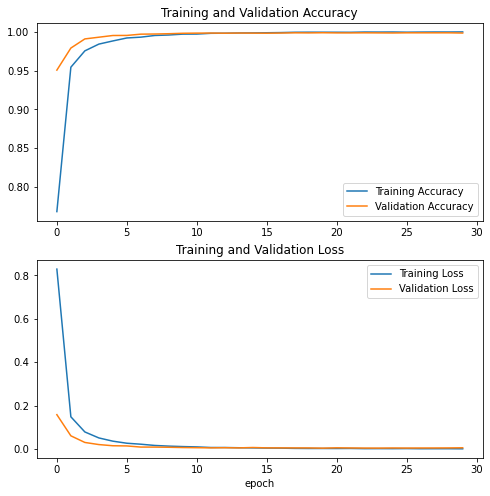

In [57]:
# plot history table 
initial_epochs = 15

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_mobilenet, label='Training Accuracy')
plt.plot(val_acc_mobilenet, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss_mobilenet, label='Training Loss')
plt.plot(val_loss_mobilenet, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

From this graph alone, we can see that the transfer learning of unfreezing layers except BN and reducing the learning rate helps to improve performance drastically. 

In [58]:
# save history table from mobilenetv2 unfrozen 

np.save('../checkpoint/hist_mobile_unfrozen_finetuned_BN.npy',hist_mobile_unfrozen2.history)

In [22]:
#  load history table 
hist_mobile_unfrozen2 = np.load("../checkpoint/hist_mobile_unfrozen_finetuned_BN.npy",allow_pickle=True).item()

In [ ]:
# Saving the model as a h5 file for possible use later.

unfrozen_mobilenet3.save(f"../models/unfrozen_mobilenet_finetuned.h5")

Choosing Checkpoint 16 as both accuracy scores for test and train matches showing that its not overfitting. 

In [39]:
checkpoint16_mobileNetv2 = create_mobilenet_unfreezeAll_finetune()
checkpoint16_mobileNetv2.load_weights('../checkpoint/training_mobilenet_unfrozen_finetune_BN/cp-0016.ckpt')

checkpoint16_mobileNetv2.evaluate(test_batches, verbose = 2)

  ...
    to  
  ['...']
327/327 - 15s - loss: 0.0048 - accuracy: 0.9982


[0.004824921968089251, 0.9981806]

In [46]:
# taking second last value since it has best score. 

summary_df.loc[8] = [
    "MobileNetV2 | Further Training 15 Epochs",
    "Horizontal_flip, Vertical_flip,\
    Shear: 20, Brightness_range: [0.6,1.2]",
    16,
    '2,252,054',
    '560s',
    hist_mobile_unfrozen2['loss'][15],
    hist_mobile_unfrozen2['val_loss'][15],
    hist_mobile_unfrozen2['accuracy'][15],
    hist_mobile_unfrozen2['val_accuracy'][15],
                    ]

summary_df

,Model,Preprocessing/Data Augmentaion,Epoch,Trainable Parameters,Duration per epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy
1,Base_Model: CNN,No Data Augmentation,10,"12,156,958",81s,0.180662,0.322523,0.942140,0.919763
2,CNN | Data Augmentation: Iteration 1,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",557s,0.454702,0.282578,0.852738,0.912390
3,CNN | Data Augmentation: Iteration 2,"Gaussian Effect, Horizontal_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",621s,0.377037,0.281738,0.874796,0.911624
4,VGG16 | Initial Phase with 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15,"2,209,790",590s,0.103075,0.106553,0.964869,0.967254
5,VGG16 | Finetuning with additional 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15 + 15,"9,289,214",560s,0.014331,0.035171,0.995489,0.992627
6,MobileNetV2 | Initial Phase with 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15,"28,182",550s,4.557377,4.248315,0.672477,0.663060
8,MobileNetV2 | Further Training 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",16,"2,252,054",560s,0.003859,0.004825,0.998752,0.998181


### Score comparison

In [47]:
summary_df.sort_values(by = 'Test Accuracy', ascending = False)

,Model,Preprocessing/Data Augmentaion,Epoch,Trainable Parameters,Duration per epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy
8,MobileNetV2 | Further Training 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",16,"2,252,054",560s,0.003859,0.004825,0.998752,0.998181
5,VGG16 | Finetuning with additional 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15 + 15,"9,289,214",560s,0.014331,0.035171,0.995489,0.992627
4,VGG16 | Initial Phase with 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15,"2,209,790",590s,0.103075,0.106553,0.964869,0.967254
1,Base_Model: CNN,No Data Augmentation,10,"12,156,958",81s,0.180662,0.322523,0.942140,0.919763
2,CNN | Data Augmentation: Iteration 1,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",557s,0.454702,0.282578,0.852738,0.912390
3,CNN | Data Augmentation: Iteration 2,"Gaussian Effect, Horizontal_flip, Shear: 20, Brightness_range: [0.6,1.2]",30,"12,156,958",621s,0.377037,0.281738,0.874796,0.911624
6,MobileNetV2 | Initial Phase with 15 Epochs,"Horizontal_flip, Vertical_flip, Shear: 20, Brightness_range: [0.6,1.2]",15,"28,182",550s,4.557377,4.248315,0.672477,0.663060


MobilenetV2 has the highest test score of 0.998 as compared to VGG16. 

One `adverse` impact using VGG16 is that we will need **huge amount of disk space** and bandwidth that makes it efficient whereas MobileNetV2 gives good predictions while running at a low-cost operations which is good for mobile devices.

**Thus, I will choose MobileNetV2 as my production model**